In [4]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""


'\nDedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.\nThis script demonstrates solving a 2D Cartesian initial value problem. It can\nbe ran serially or in parallel, and uses the built-in analysis framework to save\ndata snapshots to HDF5 files. The `plot_snapshots.py` script can be used to\nproduce plots from the saved data. It should take about 5 cpu-minutes to run.\n\nFor incompressible hydro with two boundaries, we need two tau terms for each the\nvelocity and buoyancy. Here we choose to use a first-order formulation, putting\none tau term each on auxiliary first-order gradient variables and the others in\nthe PDE, and lifting them all to the first derivative basis. This formulation puts\na tau term in the divergence constraint, as required for this geometry.\n\nTo run and plot using e.g. 4 processes:\n    $ mpiexec -n 4 python3 rayleigh_benard.py\n    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5\n'

In [2]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools
import os
from os import listdir


In [6]:
matplotlib.use('Agg')

In [4]:
# Parameters
Lx, Lz = 4,1
Nx, Nz = 256, 64

Ra_D = -1.24e5
Prandtl = 0.7
N_s2 = 4

D_0 = 0
D_H = 1
M_0 = 0
M_H = -1

dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

In [5]:
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

In [6]:
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Ra_D * Prandtl/((D_0-D_H)*Lz**3))**(-1/2)
nu = (Ra_D / (Prandtl*(D_0-D_H)*Lz**3))**(-1/2)

      
#Kuo_Bretherton Equilibrium

#Ra_M
Ra_M = Ra_D*(M_0-M_H)/(D_0-D_H)
G_D=(D_0-D_H)/Lz
G_M=(M_0-M_H)/Lz
Ra_BV=N_s2*Lz**4/(nu*kappa)
print(Ra_M)
print(Ra_BV)

x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2

Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

uz = u@ez

grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction

124000.0
496000.00000000006


In [7]:
# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, M, D, u, tau_p, tau_M1, tau_M2, tau_D1, tau_D2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p= 0")
problem.add_equation("dt(M) - kappa*div(grad_M) + lift(tau_M2) - G_M*uz= - u@grad(M)")
problem.add_equation("dt(D) - kappa*div(grad_D) + lift(tau_D2) - G_D*uz= - u@grad(D)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p)  + lift(tau_u2) = - u@grad(u)+ B_op*ez")
problem.add_equation("M(z=0) = M_0")
problem.add_equation("D(z=0) = D_0")
problem.add_equation("u(z=0) = 0")
problem.add_equation("M(z=Lz) = M_H")
problem.add_equation("D(z=Lz) = D_H")
problem.add_equation("u(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

{'LHS': Integrate(Integrate(<Field 5267612240>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 5267612240>)),
 'F': <Field 5272121424>,
 'domain': <dedalus.core.domain.Domain at 0x13a4eda50>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [8]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time


2023-06-26 15:26:23,653 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 12s, Rate: 1.1e+01/s
2023-06-26 15:26:24,177 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 5s, Rate: 2.1e+01/s
2023-06-26 15:26:24,696 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 1s, Remaining: 4s, Rate: 2.3e+01/s
2023-06-26 15:26:25,198 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 2s, Remaining: 4s, Rate: 2.4e+01/s
2023-06-26 15:26:25,694 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 2.4e+01/s
2023-06-26 15:26:26,184 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 3s, Remaining: 3s, Rate: 2.5e+01/s
2023-06-26 15:26:26,678 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 2.5e+01/s
2023-06-26 15:26:27,170 subsystems 0/1 INFO :: Building subprob

In [9]:
# Initial condition
D.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
D['g'] *= z * (Lz - z) # Damp noise at walls
D['g'] += Lz - z # Add linear background
M.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
M['g'] *= z * (Lz - z) # Damp noise at walls
M['g'] += Lz - z # Add linear background

In [10]:
# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(M, name='moist buoyancy')
snapshots.add_task(D, name='dry buoyancy')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [11]:
# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

In [12]:
# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')


In [13]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-06-26 15:26:40,764 __main__ 0/1 INFO :: Starting main loop
2023-06-26 15:26:42,460 __main__ 0/1 INFO :: Iteration=1, Time=1.250000e-01, dt=1.250000e-01, max(Re)=0.000000
2023-06-26 15:26:42,856 __main__ 0/1 INFO :: Iteration=11, Time=1.375000e+00, dt=1.250000e-01, max(Re)=0.018661
2023-06-26 15:26:43,230 __main__ 0/1 INFO :: Iteration=21, Time=2.625000e+00, dt=1.250000e-01, max(Re)=0.058826
2023-06-26 15:26:43,611 __main__ 0/1 INFO :: Iteration=31, Time=3.875000e+00, dt=1.250000e-01, max(Re)=0.255093
2023-06-26 15:26:43,982 __main__ 0/1 INFO :: Iteration=41, Time=5.125000e+00, dt=1.250000e-01, max(Re)=1.241694
2023-06-26 15:26:44,356 __main__ 0/1 INFO :: Iteration=51, Time=6.375000e+00, dt=1.250000e-01, max(Re)=6.218802
2023-06-26 15:26:44,729 __main__ 0/1 INFO :: Iteration=61, Time=7.625000e+00, dt=1.250000e-01, max(Re)=30.589609
2023-06-26 15:26:45,103 __main__ 0/1 INFO :: Iteration=71, Time=8.875000e+00, dt=1.250000e-01, max(Re)=155.306080
2023-06-26 15:26:45,717 __main__ 0/1 I

In [30]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
file_paths.sort()
print(file_paths)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5', 'snapshots/snapshots_s5.h5']


In [27]:
n=0
if not os.path.exists('buoyancygraph'):
    os.mkdir('buoyancygraph')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        buoyancy=np.maximum(moistbuoyancy,drybuoyancy-N_s2*z)
        st = file['scales/sim_time']
        simtime=np.array(st)
        for t in range(0,len(simtime)):
            mb = np.transpose(moistbuoyancy[t,:,:])
            db = np.transpose(drybuoyancy[t,:,:])
            bu = np.transpose(buoyancy[t,:,:])
            plt.contourf(bu, cmap='RdBu_r')
            plt.colorbar(label='buoyancy')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(simtime[t])
            plt.title(title)
            plt.savefig('buoyancygraph/buoyancy_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()
            


2023-06-26 15:49:58,386 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-26 15:49:58,391 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x800 -pix_fmt rgba -r 4.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y buoyancygraph.gif


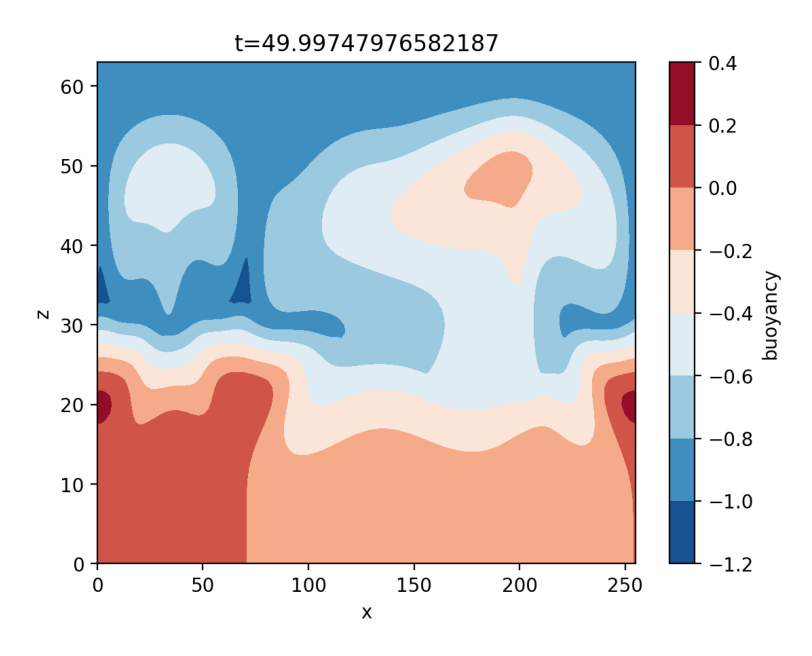

In [28]:
import matplotlib.animation as Animation
from PIL import Image


folder_dir = 'buoyancygraph'

# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()

# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]

fig = plt.figure(figsize=(16,4),dpi=200)
fig.patch.set_visible(False)
plt.axis('off')

# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save('buoyancygraph.gif',dpi=200)


In [33]:
if not os.path.exists('liquid water'):
    os.mkdir('liquid water')
n=0
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        ql=np.maximum(moistbuoyancy[:]-drybuoyancy[:]+N_s2*z,0)
        st = file['scales/sim_time']
        for t in range(0,len(st)):
            qli=np.transpose(ql[t,:,:])
            plt.contourf(qli, cmap='RdBu_r')
            plt.colorbar(label='liquid water')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig('liquid water/liquidwater_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()

2023-06-26 15:53:29,988 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-26 15:53:29,990 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x800 -pix_fmt rgba -r 4.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y liquidwater.gif


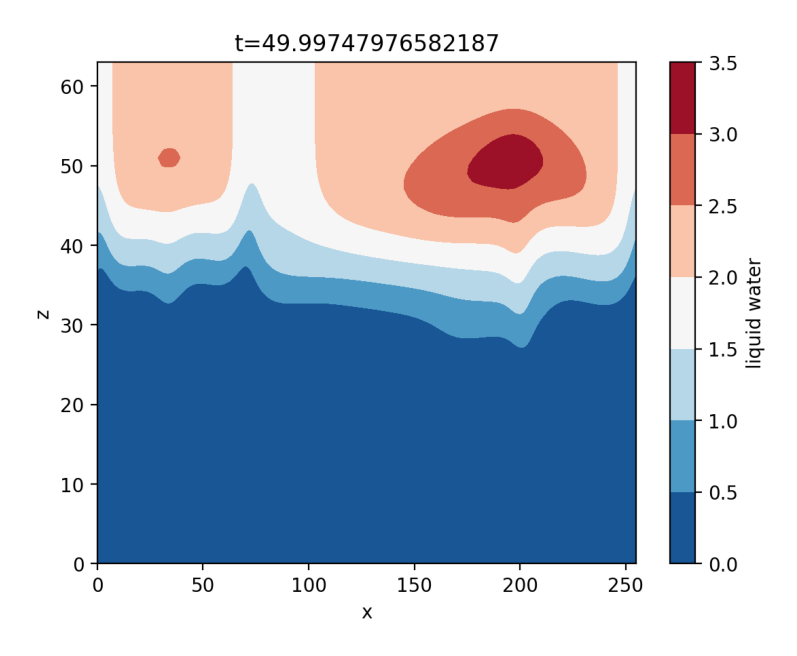

In [34]:
import matplotlib.animation as Animation
from PIL import Image


folder_dir = 'liquid water'

# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()

# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]

fig = plt.figure(figsize=(16,4),dpi=200)
fig.patch.set_visible(False)
plt.axis('off')

# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save('liquidwater.gif',dpi=200)